Goal : real world dataset to mujoco env

In [5]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [10]:
# %cd /content
# !git clone https://github.com/tonyzhaozh/act.git
# !cp -r /content/act /content/drive/MyDrive/act

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/content
Cloning into 'act'...
remote: Enumerating objects: 431, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 431 (delta 139), reused 111 (delta 111), pack-reused 257 (from 1)
Receiving objects: 100% (431/431), 10.93 MiB | 9.43 MiB/s, done.
Resolving deltas: 100% (227/227), done.


### Initialization
Install dm_control on colab and add import & helper functions

#### 1. mujoco & dm_control

In [1]:
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

print('Installing dm_control...')
!pip install -q dm_control>=1.0.25

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Installing dm_control...
env: MUJOCO_GL=egl
Checking that the dm_control installation succeeded...
Installed dm_control 1.0.25


#### 2. imports

In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation

In [3]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


#### 3. test
Should show image

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


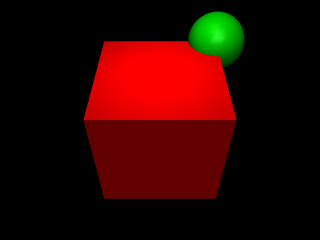

In [4]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

### ACT environment
- Aloha arm
- important parameters : gpos, camera
- gpos, action[position, quaternion(7), gripper(1)] ; observation[absolute position(6), gripper(1)]

#### 1. Physics : define scene

In [34]:
xml_path = "/content/drive/MyDrive/act/assets/bimanual_viperx_ee_transfer_cube.xml"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


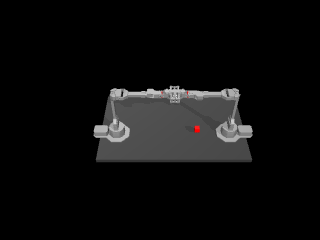

In [35]:
#@title {vertical-output: true}
physics = mujoco.Physics.from_xml_path(xml_path)
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [49]:
physics.data.qpos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0.        , -0.96      ,  1.16      ,  0.        , -0.3       ,
        0.        ,  0.02239   , -0.02239   ,  0.        , -0.96      ,
        1.16      ,  0.        , -0.3       ,  0.        ,  0.02239   ,
       -0.02239   ,  0.01161672,  0.57323523,  0.05      ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [23]:
#@title adjust camera position (how to get rotation of camera?)
camera = mujoco.Camera(physics)
camera_matrix = camera.matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 2. Task : task definition

##### constants

In [17]:
import pathlib

### Task parameters
DATA_DIR = '<put your data dir here>'
SIM_TASK_CONFIGS = {
    'sim_transfer_cube_scripted':{
        'dataset_dir': DATA_DIR + '/sim_transfer_cube_scripted',
        'num_episodes': 50,
        'episode_len': 400,
        'camera_names': ['top']
    },

    'sim_transfer_cube_human':{
        'dataset_dir': DATA_DIR + '/sim_transfer_cube_human',
        'num_episodes': 50,
        'episode_len': 400,
        'camera_names': ['top']
    },

    'sim_insertion_scripted': {
        'dataset_dir': DATA_DIR + '/sim_insertion_scripted',
        'num_episodes': 50,
        'episode_len': 400,
        'camera_names': ['top']
    },

    'sim_insertion_human': {
        'dataset_dir': DATA_DIR + '/sim_insertion_human',
        'num_episodes': 50,
        'episode_len': 500,
        'camera_names': ['top']
    },
}

### Simulation envs fixed constants
DT = 0.02
JOINT_NAMES = ["waist", "shoulder", "elbow", "forearm_roll", "wrist_angle", "wrist_rotate"]
START_ARM_POSE = [0, -0.96, 1.16, 0, -0.3, 0, 0.02239, -0.02239,  0, -0.96, 1.16, 0, -0.3, 0, 0.02239, -0.02239]

# XML_DIR = str(pathlib.Path(__file__).parent.resolve()) + '/assets/' # note: absolute path

# Left finger position limits (qpos[7]), right_finger = -1 * left_finger
MASTER_GRIPPER_POSITION_OPEN = 0.02417
MASTER_GRIPPER_POSITION_CLOSE = 0.01244
PUPPET_GRIPPER_POSITION_OPEN = 0.05800
PUPPET_GRIPPER_POSITION_CLOSE = 0.01844

# Gripper joint limits (qpos[6])
MASTER_GRIPPER_JOINT_OPEN = 0.3083
MASTER_GRIPPER_JOINT_CLOSE = -0.6842
PUPPET_GRIPPER_JOINT_OPEN = 1.4910
PUPPET_GRIPPER_JOINT_CLOSE = -0.6213

############################ Helper functions ############################

MASTER_GRIPPER_POSITION_NORMALIZE_FN = lambda x: (x - MASTER_GRIPPER_POSITION_CLOSE) / (MASTER_GRIPPER_POSITION_OPEN - MASTER_GRIPPER_POSITION_CLOSE)
PUPPET_GRIPPER_POSITION_NORMALIZE_FN = lambda x: (x - PUPPET_GRIPPER_POSITION_CLOSE) / (PUPPET_GRIPPER_POSITION_OPEN - PUPPET_GRIPPER_POSITION_CLOSE)
MASTER_GRIPPER_POSITION_UNNORMALIZE_FN = lambda x: x * (MASTER_GRIPPER_POSITION_OPEN - MASTER_GRIPPER_POSITION_CLOSE) + MASTER_GRIPPER_POSITION_CLOSE
PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN = lambda x: x * (PUPPET_GRIPPER_POSITION_OPEN - PUPPET_GRIPPER_POSITION_CLOSE) + PUPPET_GRIPPER_POSITION_CLOSE
MASTER2PUPPET_POSITION_FN = lambda x: PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN(MASTER_GRIPPER_POSITION_NORMALIZE_FN(x))

MASTER_GRIPPER_JOINT_NORMALIZE_FN = lambda x: (x - MASTER_GRIPPER_JOINT_CLOSE) / (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE)
PUPPET_GRIPPER_JOINT_NORMALIZE_FN = lambda x: (x - PUPPET_GRIPPER_JOINT_CLOSE) / (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE)
MASTER_GRIPPER_JOINT_UNNORMALIZE_FN = lambda x: x * (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE) + MASTER_GRIPPER_JOINT_CLOSE
PUPPET_GRIPPER_JOINT_UNNORMALIZE_FN = lambda x: x * (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE) + PUPPET_GRIPPER_JOINT_CLOSE
MASTER2PUPPET_JOINT_FN = lambda x: PUPPET_GRIPPER_JOINT_UNNORMALIZE_FN(MASTER_GRIPPER_JOINT_NORMALIZE_FN(x))

MASTER_GRIPPER_VELOCITY_NORMALIZE_FN = lambda x: x / (MASTER_GRIPPER_POSITION_OPEN - MASTER_GRIPPER_POSITION_CLOSE)
PUPPET_GRIPPER_VELOCITY_NORMALIZE_FN = lambda x: x / (PUPPET_GRIPPER_POSITION_OPEN - PUPPET_GRIPPER_POSITION_CLOSE)

MASTER_POS2JOINT = lambda x: MASTER_GRIPPER_POSITION_NORMALIZE_FN(x) * (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE) + MASTER_GRIPPER_JOINT_CLOSE
MASTER_JOINT2POS = lambda x: MASTER_GRIPPER_POSITION_UNNORMALIZE_FN((x - MASTER_GRIPPER_JOINT_CLOSE) / (MASTER_GRIPPER_JOINT_OPEN - MASTER_GRIPPER_JOINT_CLOSE))
PUPPET_POS2JOINT = lambda x: PUPPET_GRIPPER_POSITION_NORMALIZE_FN(x) * (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE) + PUPPET_GRIPPER_JOINT_CLOSE
PUPPET_JOINT2POS = lambda x: PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN((x - PUPPET_GRIPPER_JOINT_CLOSE) / (PUPPET_GRIPPER_JOINT_OPEN - PUPPET_GRIPPER_JOINT_CLOSE))

MASTER_GRIPPER_JOINT_MID = (MASTER_GRIPPER_JOINT_OPEN + MASTER_GRIPPER_JOINT_CLOSE)/2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### utils
sample_box_pose : provide random box pose for initialization

In [32]:
def sample_box_pose():
    x_range = [0.0, 0.2]
    y_range = [0.4, 0.6]
    z_range = [0.05, 0.05]

    ranges = np.vstack([x_range, y_range, z_range])
    cube_position = np.random.uniform(ranges[:, 0], ranges[:, 1])

    cube_quat = np.array([1, 0, 0, 0])
    return np.concatenate([cube_position, cube_quat])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### a) BimanualViperEETask
- basic task class inherited from dm_control.suite.base.task
- @get_observation : defines camera pose
-


In [27]:
from dm_control.suite import base
import collections
class BimanualViperXEETask(base.Task):
    def __init__(self, random=None):
        super().__init__(random=random)

    def before_step(self, action, physics):
        a_len = len(action) // 2
        action_left = action[:a_len]
        action_right = action[a_len:]

        # set mocap position and quat
        # left
        np.copyto(physics.data.mocap_pos[0], action_left[:3])
        np.copyto(physics.data.mocap_quat[0], action_left[3:7])
        # right
        np.copyto(physics.data.mocap_pos[1], action_right[:3])
        np.copyto(physics.data.mocap_quat[1], action_right[3:7])

        # set gripper
        g_left_ctrl = PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN(action_left[7])
        g_right_ctrl = PUPPET_GRIPPER_POSITION_UNNORMALIZE_FN(action_right[7])
        np.copyto(physics.data.ctrl, np.array([g_left_ctrl, -g_left_ctrl, g_right_ctrl, -g_right_ctrl]))

    def initialize_robots(self, physics):
        # reset joint position
        physics.named.data.qpos[:16] = START_ARM_POSE

        # reset mocap to align with end effector //set camera
        # to obtain these numbers:
        # (1) make an ee_sim env and reset to the same start_pose
        # (2) get env._physics.named.data.xpos['vx300s_left/gripper_link']
        #     get env._physics.named.data.xquat['vx300s_left/gripper_link']
        #     repeat the same for right side
        np.copyto(physics.data.mocap_pos[0], [-0.31718881, 0.5, 0.29525084])
        np.copyto(physics.data.mocap_quat[0], [1, 0, 0, 0])
        # right
        np.copyto(physics.data.mocap_pos[1], np.array([0.31718881, 0.49999888, 0.29525084]))
        np.copyto(physics.data.mocap_quat[1],  [1, 0, 0, 0])

        # reset gripper control
        close_gripper_control = np.array([
            PUPPET_GRIPPER_POSITION_CLOSE,
            -PUPPET_GRIPPER_POSITION_CLOSE,
            PUPPET_GRIPPER_POSITION_CLOSE,
            -PUPPET_GRIPPER_POSITION_CLOSE,
        ])
        np.copyto(physics.data.ctrl, close_gripper_control)

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode."""
        super().initialize_episode(physics)

    @staticmethod
    def get_qpos(physics):
        qpos_raw = physics.data.qpos.copy()
        left_qpos_raw = qpos_raw[:8]
        right_qpos_raw = qpos_raw[8:16]
        left_arm_qpos = left_qpos_raw[:6]
        right_arm_qpos = right_qpos_raw[:6]
        left_gripper_qpos = [PUPPET_GRIPPER_POSITION_NORMALIZE_FN(left_qpos_raw[6])]
        right_gripper_qpos = [PUPPET_GRIPPER_POSITION_NORMALIZE_FN(right_qpos_raw[6])]
        return np.concatenate([left_arm_qpos, left_gripper_qpos, right_arm_qpos, right_gripper_qpos])

    @staticmethod
    def get_qvel(physics):
        qvel_raw = physics.data.qvel.copy()
        left_qvel_raw = qvel_raw[:8]
        right_qvel_raw = qvel_raw[8:16]
        left_arm_qvel = left_qvel_raw[:6]
        right_arm_qvel = right_qvel_raw[:6]
        left_gripper_qvel = [PUPPET_GRIPPER_VELOCITY_NORMALIZE_FN(left_qvel_raw[6])]
        right_gripper_qvel = [PUPPET_GRIPPER_VELOCITY_NORMALIZE_FN(right_qvel_raw[6])]
        return np.concatenate([left_arm_qvel, left_gripper_qvel, right_arm_qvel, right_gripper_qvel])

    @staticmethod
    def get_env_state(physics):
        raise NotImplementedError

    def get_observation(self, physics):
        # note: it is important to do .copy()
        obs = collections.OrderedDict()
        obs['qpos'] = self.get_qpos(physics)
        obs['qvel'] = self.get_qvel(physics)
        obs['env_state'] = self.get_env_state(physics)
        obs['images'] = dict()
        obs['images']['top'] = physics.render(height=480, width=640, camera_id='top')
        obs['images']['angle'] = physics.render(height=480, width=640, camera_id='angle')
        obs['images']['vis'] = physics.render(height=480, width=640, camera_id='front_close')
        # used in scripted policy to obtain starting pose
        obs['mocap_pose_left'] = np.concatenate([physics.data.mocap_pos[0], physics.data.mocap_quat[0]]).copy()
        obs['mocap_pose_right'] = np.concatenate([physics.data.mocap_pos[1], physics.data.mocap_quat[1]]).copy()

        # used when replaying joint trajectory
        obs['gripper_ctrl'] = physics.data.ctrl.copy()
        return obs

    def get_reward(self, physics):
        raise NotImplementedError

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### b) TransferCubeEETask
transfer cube task inferited from Bimanulal Viper EE task

In [28]:
class TransferCubeEETask(BimanualViperXEETask):
    def __init__(self, random=None):
        super().__init__(random=random)
        self.max_reward = 4

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode."""
        self.initialize_robots(physics)
        # randomize box position
        cube_pose = sample_box_pose()
        box_start_idx = physics.model.name2id('red_box_joint', 'joint')
        np.copyto(physics.data.qpos[box_start_idx : box_start_idx + 7], cube_pose)
        # print(f"randomized cube position to {cube_position}")

        super().initialize_episode(physics)

    @staticmethod
    def get_env_state(physics):
        env_state = physics.data.qpos.copy()[16:]
        return env_state

    def get_reward(self, physics):
        # return whether left gripper is holding the box
        all_contact_pairs = []
        for i_contact in range(physics.data.ncon):
            id_geom_1 = physics.data.contact[i_contact].geom1
            id_geom_2 = physics.data.contact[i_contact].geom2
            name_geom_1 = physics.model.id2name(id_geom_1, 'geom')
            name_geom_2 = physics.model.id2name(id_geom_2, 'geom')
            contact_pair = (name_geom_1, name_geom_2)
            all_contact_pairs.append(contact_pair)

        touch_left_gripper = ("red_box", "vx300s_left/10_left_gripper_finger") in all_contact_pairs
        touch_right_gripper = ("red_box", "vx300s_right/10_right_gripper_finger") in all_contact_pairs
        touch_table = ("red_box", "table") in all_contact_pairs

        reward = 0
        if touch_right_gripper:
            reward = 1
        if touch_right_gripper and not touch_table: # lifted
            reward = 2
        if touch_left_gripper: # attempted transfer
            reward = 3
        if touch_left_gripper and not touch_table: # successful transfer
            reward = 4
        return reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### initialize task

In [29]:
task = TransferCubeEETask(random=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 3. Set environment

In [37]:
from dm_control.rl import control
env = control.Environment(physics, task, time_limit=20, control_timestep=DT,
                                  n_sub_steps=None, flat_observation=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 4. Start rendering

In [38]:
ts = env.reset()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


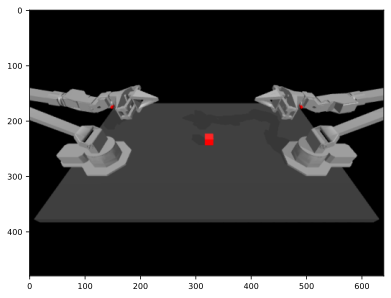

In [43]:
#@title {vertical-output: true}
ax = plt.subplot()
plt_img = ax.imshow(ts.observation['images']["angle"]) # camera name: top, angle, vis
plt.ion()

### H2O dataset visualization
repo : H2O player

In [59]:
# example : fig. 65
object_path = "/content/drive/MyDrive/subset_h1_0_cam2/obj_pose/000065.txt"
cam_intrinsics_path = "/content/drive/MyDrive/subset_h1_0_cam2/cam_intrinsics.txt"
img_path = "/content/drive/MyDrive/subset_h1_0_cam2/images/000065.png"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### load object position (bounding box projection)

In [61]:
import cv2
def read_text(text_path, offset=0, half=0):
    with open(text_path, 'r') as txt_file:
        data = txt_file.readline().split(" ")
        data = list(filter(lambda x: x != "", data))

    if half:
        data_list = np.array(data)[offset:half].tolist(
        ) + np.array(data)[half+offset:].tolist()
        return np.array(data_list).reshape((-1, 3)).astype(np.float32)
    else:
        return np.array(data)[offset:].reshape((-1, 3)).astype(np.float32)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
cv_img = cv2.imread(img_path)
points = read_text(object_path, 1)
cam_fx, cam_fy, cam_cx, cam_cy, _, _ = read_text(cam_intrinsics_path).reshape((6))
camera_matrix = np.array([[cam_fx, 0, cam_cx], [0, cam_fy, cam_cy], [0, 0, 1]])

# print(points)
img_points, _ = cv2.projectPoints(points, np.array([[0, 0, 0]]).astype(
    np.float32), np.array([[0, 0, 0]]).astype(np.float32), camera_matrix, None)
# cv2.line(cv_img, (541, 561), (547, 635), (0, 255, 0), 5) cv2 is depricated

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
points

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[-0.08191068,  0.30340892,  0.6769306 ],
       [-0.11295148,  0.2224988 ,  0.7231966 ],
       [-0.11326854,  0.32538196,  0.7673982 ],
       [-0.00678684,  0.3435491 ,  0.7258764 ],
       [-0.00646978,  0.24066596,  0.6816748 ],
       [-0.15703453,  0.2632687 ,  0.6279848 ],
       [-0.1573516 ,  0.36615187,  0.6721864 ],
       [-0.0508699 ,  0.384319  ,  0.6306646 ],
       [-0.05055283,  0.28143585,  0.58646303],
       [-0.11311001,  0.27394038,  0.74529743],
       [-0.15719306,  0.3147103 ,  0.6500856 ],
       [-0.05071137,  0.33287743,  0.6085638 ],
       [-0.00662831,  0.29210752,  0.7037756 ],
       [-0.134993  ,  0.24288376,  0.67559075],
       [-0.13531007,  0.34576693,  0.7197923 ],
       [-0.02882837,  0.36393407,  0.67827046],
       [-0.0285113 ,  0.2610509 ,  0.6340689 ],
       [-0.05971063,  0.23158237,  0.70243573],
       [-0.06002769,  0.33446553,  0.7466373 ],
       [-0.10411075,  0.37523544,  0.6514255 ],
       [-0.10379369,  0.27235228,  0.607

In [116]:
# draw square
order = [1, 2, 3, 4, 1, 5, 2, 6, 3, 7, 4, 8, 5, 6, 7, 8, 5]
x_square = []
y_square = []
z_square = []

for i in range(0, len(order)):
    x_square.append(points[order[i]][0])
    y_square.append(points[order[i]][1])
    z_square.append(points[order[i]][2])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


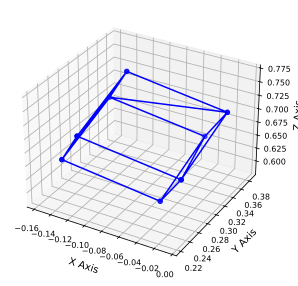

In [117]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(x_square, y_square, z_square, c='blue', marker='o')
ax.plot(x_square, y_square, z_square, color='blue')

# Add labels for clarity
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()

In [70]:
cv2.imwrite('/content/test.png', cv_img)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True